# Tutorial 10 - Clustering

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe a case where clustering would be an appropriate tool, and what insight it would bring from the data.
* Explain the K-means clustering algorithm.
* Interpret the output of a K-means cluster analysis.
* Perform K-means clustering in R
* Visualize the output of K-means clustering in R using a coloured scatter plot 
* Identify when it is necessary to scale variables before clustering and do this using R
* Use the elbow method to choose the number of clusters for k-means
* Describe advantages, limitations and assumptions of the kmeans clustering algorithm.

This worksheet covers parts of [the Clustering chapter](https://datasciencebook.ca/clustering.html) of the online textbook. You should read this chapter before attempting the worksheet.

In [ ]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

# 1. Pokemon

We will be working with the Pokemon dataset from Kaggle, which can be found [here.](https://www.kaggle.com/abcsds/pokemon)
This dataset compiles the statistics on 721 Pokemon. The information in this dataset includes Pokemon name, type, health points, attack strength, defensive strength, speed points etc. These are values that apply to a Pokemon's abilities (higher values are better). We are interested in seeing if there are any sub-groups/clusters of pokemon based on these statistics. And if so, how many sub-groups/clusters there are.

![](https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif)

Source: https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif


**Question 1.0**
<br> {points: 1}

Use `read_csv` to load `pokemon.csv` from the `data/` folder. 

*Assign your answer to an object called `pokemon_full`.*

In [ ]:
pokemon_full <- read_csv("data/pokemon.csv")
pokemon_full

In [ ]:
test_1.0()

**Question 1.1**
<br> {points: 1}

To start exploring the Pokemon data, create a scatter plot matrix (or pairplot) using `ggpairs`. The plot should only contain the columns `Total` to `Speed` from `pm_data`. You can check the data wrangling chapter in the textbook to recall how to select a range of columns using `select` with `:`.

*Assign your answer to an object called `pokemon_pairs`. Make sure to set a suitable size for the plot.*

In [ ]:
# options(...)
#
# ... <- pokemon_full |> ... |>
#     ggpairs(aes(alpha = 0.05)) +
#     theme(text = element_text(size = 20))

 options(repr.plot.height = 7, repr.plot.width = 15)

pokemon_pairs <- pokemon_full |>
    select(Total:Speed) |>
     ggpairs(aes(alpha = 0.05)) +
     theme(text = element_text(size = 20))

pokemon_pairs

In [ ]:
test_1.1()

**Question 1.2** 
<br> {points: 1}

From the pairplot above, it does not look like the pokemon are separated into clear groups in any of the pairwise variable scatterplots. Here, we will continue exploring the relationship between `Speed` and `Defense` and see what happens if we try to cluster the data points on these two variables although there are no visually discernable variables in the chart.

First, select the columns `Speed` and `Defense`, creating a new dataframe with only those columns.

*Assign your answer to an object named `pokemon`.*

In [ ]:
pokemon <- pokemon_full |>
    select(Speed, Defense)
pokemon

In [ ]:
test_1.2()

**Question 1.3**
<br> {points: 1}

Next, create a scatter plot of only these two variables so that we can look close at their relationship. Put the `Speed` variable on the x-axis, and the `Defense` variable on the y-axis.

*Assign your plot to an object called `pokemon_scatter`. Don't forget to do everything needed to make an effective visualization, including setting an appropriate `alpha` value of the points.*

In [ ]:
pokemon_scatter <- pokemon |>
    ggplot(aes(x = Speed, y = Defense)) +
    geom_point() +
    xlab("Pokemon's Speed stat") +
    ylab("Pokemon's Defense stat")
pokemon_scatter

In [ ]:
test_1.3()

**Question 1.4.1** 
<br> {points: 3}

The chart above confirms what we saw in the pairplot; there doesn't seem to be visually distinct clusters of points in these two dimensions. Could it still be informative to run clustering with this data? Let's find out by using K-Means to cluster the Pokemon based on their `Speed` and `Defense`.

So far when using K-Means, we have scaled our input features. Will it matter much for our clustering if we scale our variables for the pokemon data? Is there any argument against scaling here?

The two variables are already roughly on a comparable scale. Note that scaling probably wouldn't hurt as far as finding good quality clusters is concerned, the only mild downside to scaling is that it would get rid of the nice interpretable plot axes.

**Question 1.4.2**
<br> {points: 1}

Now, let's use K-means to cluster the Pokemon based on their `Speed` and `Defense` variables.
- Create a recipe named `pokemon_recipe` that standardizes the data
- Create a model specification named `pokemon_spec` for K-means clustering with 4 clusters. 
- Fit the model using a `tidymodels` workflow; call the output of the `fit()` function `pokemon_clustering`.

*Assign your answers to objects called `pokemon_recipe`, `pokemon_spec`, and `pokemon_clustering`.*

**Note:** We set the random seed here because K-means initializes observations to random clusters.

In [ ]:
#DON'T CHANGE THE SEED VALUE BELOW!
set.seed(2019)

pokemon_recipe <- recipe( ~ ., data = pokemon) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

pokemon_spec <- k_means(num_clusters = 4) |>
    set_engine("stats")

pokemon_clustering <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(pokemon_spec) |>
    fit(data = pokemon)

pokemon_clustering

In [ ]:
test_1.4.2()

**Question 1.5**
<br> {points: 1}

Let's visualize the clusters we built in `pokemon_clustering`. Use the `augment` function and create a coloured scatter plot of `Speed` (x-axis) vs `Defense` (y-axis) with the points coloured by their cluster assignment. 

Name this plot `pokemon_clustering_plot`.

In [ ]:
 options(repr.plot.height = 7, repr.plot.width = 7)

pokemon_clustering_labelled <- pokemon_clustering |>
    augment(pokemon)

pokemon_clustering_plot <- pokemon_clustering_labelled |>
    ggplot(aes(x = Speed, y = Defense, color= .pred_cluster)) +
    geom_point() +
    xlab("Speed stats") +
    ylab("Defense stats") +
    labs(color = "cluster predictions")

pokemon_clustering_plot

In [ ]:
test_1.5()

**Question 1.6**
<br> {points: 3}

Below you can see multiple initializations of k-means with different seeds for `K = 4`. Can you explain what is happening and how we can mitigate this in the `kmeans` function?

![](imgs/multiple_initializations.png)

This happens because of the random selection of initial cluster centroids. To counter this, we can use the nstart argument in the set_engine function. nstart tells R how many times to run the K=means algorithm using different random starts, and returns the best one.

**Question 1.7**
<br> {points: 1}

We know that comparing how the WSSD varies for multiple values of $K$ is an important step of selecting a suitable clustering model. That's what we will do next!

For this exercise, you will calculate the total within-cluster sum-of-squared distances for $K$ = 1 to $K$ = 10.

1. Create a tibble with the desired values of $K$.
2. Create a new model specification that sets `nstart` to 10 and tells `k_means` you want to tune the number of clusters.
3. Create a new workflow that uses `tune_cluster` to tune the number of clusters
4. Use the `collect_metrics` function to collect the results.
5. Use `filter`, `select`, and `mutate` functions to construct a tibble with two columns named `num_clusters` and `total_WSSD`. Store that tibble in an object named `elbow_stats`.


*Assign your answer to a tibble object named `elbow_stats`. It should have the columns `num_clusters` and `total_WSSD`.*

In [116]:
set.seed(2020) # DO NOT REMOVE

ks <- tibble(num_clusters = 1:10)

kmeans_spec_tune <- k_means(num_clusters = tune()) |>
        set_engine("stats", nstart = 10)

tune_cluster <- workflow() |>
        add_recipe(pokemon_recipe) |>
        add_model(kmeans_spec_tune) |>
        tune_cluster(resamples = apparent(pokemon), grid = ks) |>
        collect_metrics()

elbow_stats <- tune_cluster |>
        mutate(total_WSSD = mean) |>
        filter(.metric == "sse_within_total") |>
        select(num_clusters, total_WSSD)

elbow_stats

num_clusters,total_WSSD
<int>,<dbl>
1,1598.0000
2,1031.4596
3,640.4274
⋮,⋮
8,267.6408
9,235.6118
10,214.2753


In [117]:
test_1.7()

Test passed 🎉
Test passed 😀
Test passed 🥇
Test passed 🌈
Test passed 🎉
Test passed 😀
[1] "Success!"


**Question 1.8**
<br> {points: 1}

Let's visualize how WSSD changes for as we vary the value of $K$. To do this, create the elbow plot. Put the within-cluster sum of squares on the y-axis, and the number of clusters on the x-axis.

*Assign your plot to an object called `elbow_plot`*.

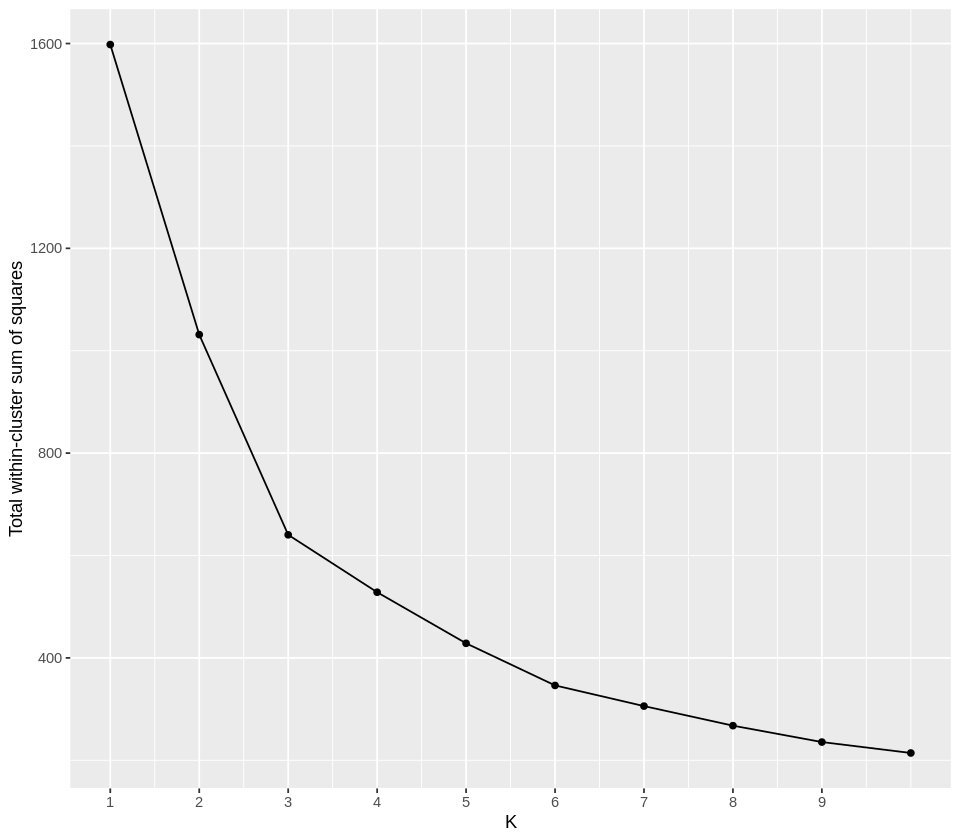

In [118]:
options(repr.plot.width = 8, repr.plot.height = 7)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = num_clusters, y = total_WSSD)) +
    geom_point() +
    geom_line() +
    xlab("K") +
    ylab("Total within-cluster sum of squares") +
    scale_x_continuous(breaks = 1:9) 

elbow_plot

In [119]:
test_1.8()

Test passed 🎊
Test passed 😀
Test passed 🎉
Test passed 🎉
Test passed 🎉
[1] "Success!"


**Question 1.9** 
<br> {points: 3}

Based on the elbow plot above, what value of $K$ would you choose? Explain why.

choose K as 3 since increasing K further than this only decreased the total within-cluster sum of squares a small amount

**Question 1.10**
<br> {points: 3}

Using the value that you chose for $K$, perform the K-means algorithm, set `nstart = 10` and assign your answer to an object called `pokemon_final_kmeans`. 

Augment the data with the final cluster labels and assign your answer to an object called `pokemon_final_clusters`. 

Finally, create a plot called `pokemon_final_clusters_plot` to visualize the clusters. Include a title, colour the points by the cluster and make sure your axes are human-readable.

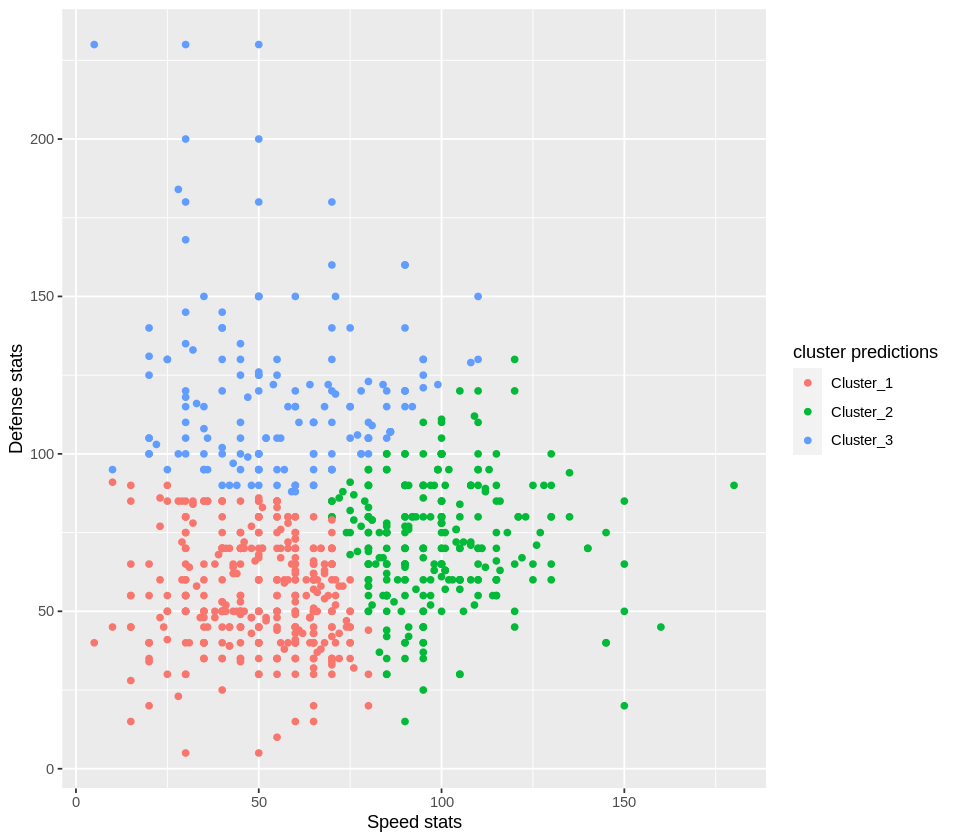

In [120]:
set.seed(2019) # DO NOT REMOVE

options(repr.plot.height = 6, repr.plot.width = 8)

final_pokemon_spec <- k_means(num_clusters = 3) |> set_engine("stats", nstart=10)

final_pokemon_clustering <- workflow() |>
    add_recipe(pokemon_recipe) |>
    add_model(final_pokemon_spec) |>
    fit(data = pokemon)
pokemon_final_clusters <- final_pokemon_clustering |> augment(pokemon)

pokemon_final_clusters_plot <- ggplot(pokemon_final_clusters, aes(x = Speed, y = Defense, color = .pred_cluster)) +
    geom_point(alpha = 0.5, size = 2) +
    labs(x = "Speed points (standardized)",
         y = "Defense points (standardized)",
        colour = "Cluster") +
 ggtitle(
        label = "k-means clustering with 3 clusters",
        subtitle = "") +
    theme(text = element_text(size = 20))

pokemon_final_clusters_plot

In [121]:
test_1.10()

Test passed 🥇
Test passed 😀
Test passed 🌈
Test passed 😀
Test passed 🌈
[1] "Success!"


**Question 1.11** 
<br> {points: 3}

This looks perhaps a bit better than when we used $K=4$ clusters originally, but is it really a lot better? Use this plot and the elbow plot from Question 1.8 to reason about what might be going on here.

Basically this data doesn't cluster very obviously. It looks like we're subdividing a single cluster right from the beginning. Along these lines, there is only a weak elbow in the elbow plot, also indicating that there is not a clear, distinctive clustering of the data.


# 2. Tourism Reviews

![](https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif)
Source: https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif

The Ministry of Land, Infrastructure, Transport and Tourism of Japan is interested in knowing the type of tourists that visit East Asia. They know the [majority of their visitors come from this region](https://statistics.jnto.go.jp/en/graph/) and would like to stay competitive in the region to keep growing the tourism industry. For this, they have hired us to perform segmentation of the tourists. A [dataset from TripAdvisor](https://archive.ics.uci.edu/ml/datasets/Travel+Reviews) has been scraped and it's provided to you.

This dataset contains the following variables:

- User ID : Unique user id 
- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

**Question 2.0**
<br> {points: 3}

Load the data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv and clean it so that only the Category # columns are in the data frame (i.e., remove the `User ID` column). 

Assign your answer to an object called `clean_reviews`.

In [122]:
clean_reviews <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv") |>
    select(-1) |>
    rename_all(~gsub(" ", "_", .))
    

clean_reviews

Rows: 980 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): User ID
dbl (10): Category 1, Category 2, Category 3, Category 4, Category 5, Catego...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46
0.93,0.56,1.13,0.51,1.34,2.36,3.18,2.87,1.34,2.40


In [123]:
test_that('Did not create an object called clean_reviews', {
    expect_true(exists("clean_reviews"))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.


Test passed 🎊


**Question 2.1**
<br> {points: 3}

Perform K-means and vary $K$ from 1 to 10 to identify the optimal number of clusters. Use `nstart = 100`. Assign your answer to a tibble object called `tourism_elbow_stats` that has the columns `num_clusters` and `total_WSSD`.

Afterwards, create an elbow plot to help you choose $K$. Assign your answer to an object called `tourism_elbow_plot`.

! Apparent: preprocessor 1/1, model 10/10: did not converge in 10 iterations



num_clusters,total_WSSD
<int>,<dbl>
1,9790.000
2,7759.473
3,7090.652
⋮,⋮
8,5055.061
9,4841.085
10,4678.027


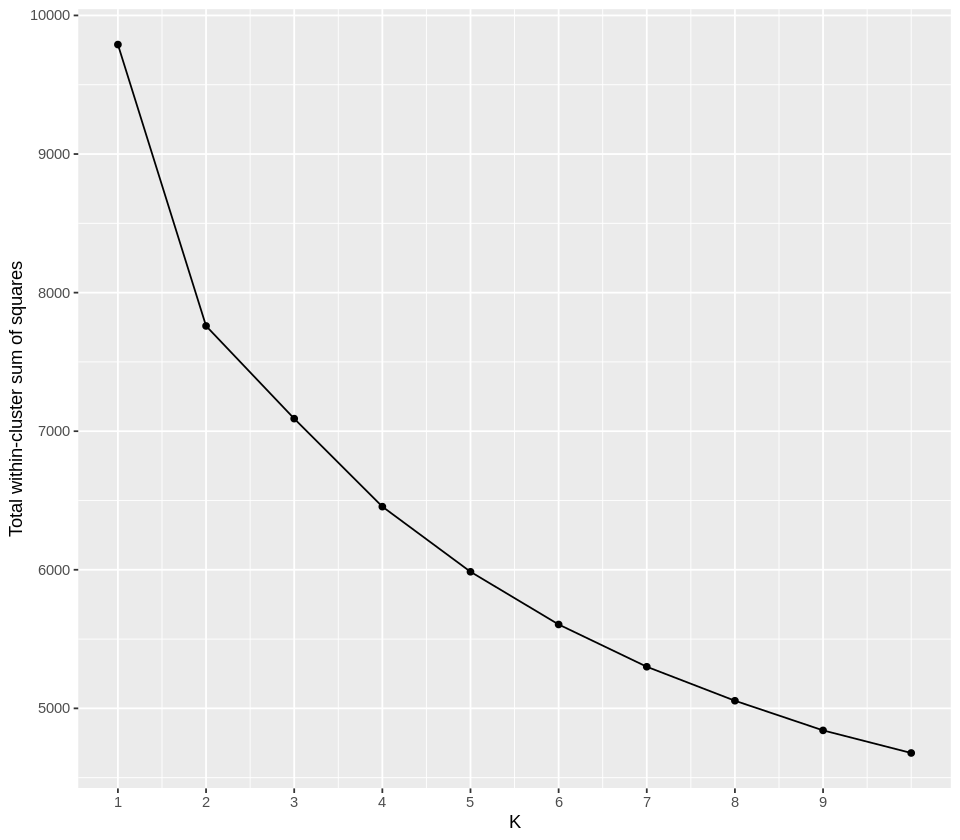

In [124]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

ks <- tibble(num_clusters = 1:10)

kmeans_spec_tune <- k_means(num_clusters = tune()) |>
        set_engine("stats", nstart = 100)

review_recipe <- recipe( ~ ., data = clean_reviews) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tune_cluster <- workflow() |>
        add_recipe(review_recipe) |>
        add_model(kmeans_spec_tune) |>
        tune_cluster(resamples = apparent(clean_reviews), grid = ks) |>
        collect_metrics()

tourism_elbow_stats <- tune_cluster |>
        mutate(total_WSSD = mean) |>
        filter(.metric == "sse_within_total") |>
        select(num_clusters, total_WSSD)

tourism_elbow_stats

tourism_elbow_plot <- tourism_elbow_stats |>
    ggplot(aes(x = num_clusters, y = total_WSSD)) +
    geom_point() +
    geom_line() +
    xlab("K") +
    ylab("Total within-cluster sum of squares") +
    scale_x_continuous(breaks = 1:9) 

tourism_elbow_plot

In [125]:
test_that('Did not create an object called elbow_stats', {
    expect_true(exists('elbow_stats'))
})
test_that('Did not create a plot called tourism_elbow_plot', {
    expect_true(exists('tourism_elbow_plot'))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.

Test passed 🎊
Test passed 🥳


**Question 2.2** 
<br> {points: 3}

From the elbow plot above, which $k$ should you choose? Explain why you chose that $k$.

k = 2 since increasing k doesnt have a significant change in the total within clusters


**Question 2.3**
<br> {points: 3}

Run K-means again, with the optimal $K$, and assign your answer to an object called `reviews_clusters`. Use `nstart = 100`. Then, use the `augment` function to get the cluster assignments for each point. Name the data frame `cluster_assignments`.

In [136]:
#DONT CHANGE THIS SEED VALUE
set.seed(2019)

final_spec <- k_means(num_clusters = 2) |>
    set_engine("stats", nstart = 100)

reviews_clusters <- workflow() |>
    add_recipe(review_recipe) |>
    add_model(final_spec) |>
    fit(data = clean_reviews)

cluster_assignments <- augment(reviews_clusters, clean_reviews)

cluster_assignments

Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,.pred_cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42,Cluster_1
1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32,Cluster_1
1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50,Cluster_2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02,Cluster_2
0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46,Cluster_2
0.93,0.56,1.13,0.51,1.34,2.36,3.18,2.87,1.34,2.40,Cluster_1


For the following 2 questions use the following plot as reference. 

> The visualization below is a density plot, you can think of it as a smoothed version of a histogram. Density plots are more effective for comparing multiple distributions. What we are looking for with these visualizations, is to see which variables have difference distributions between the different clusters.

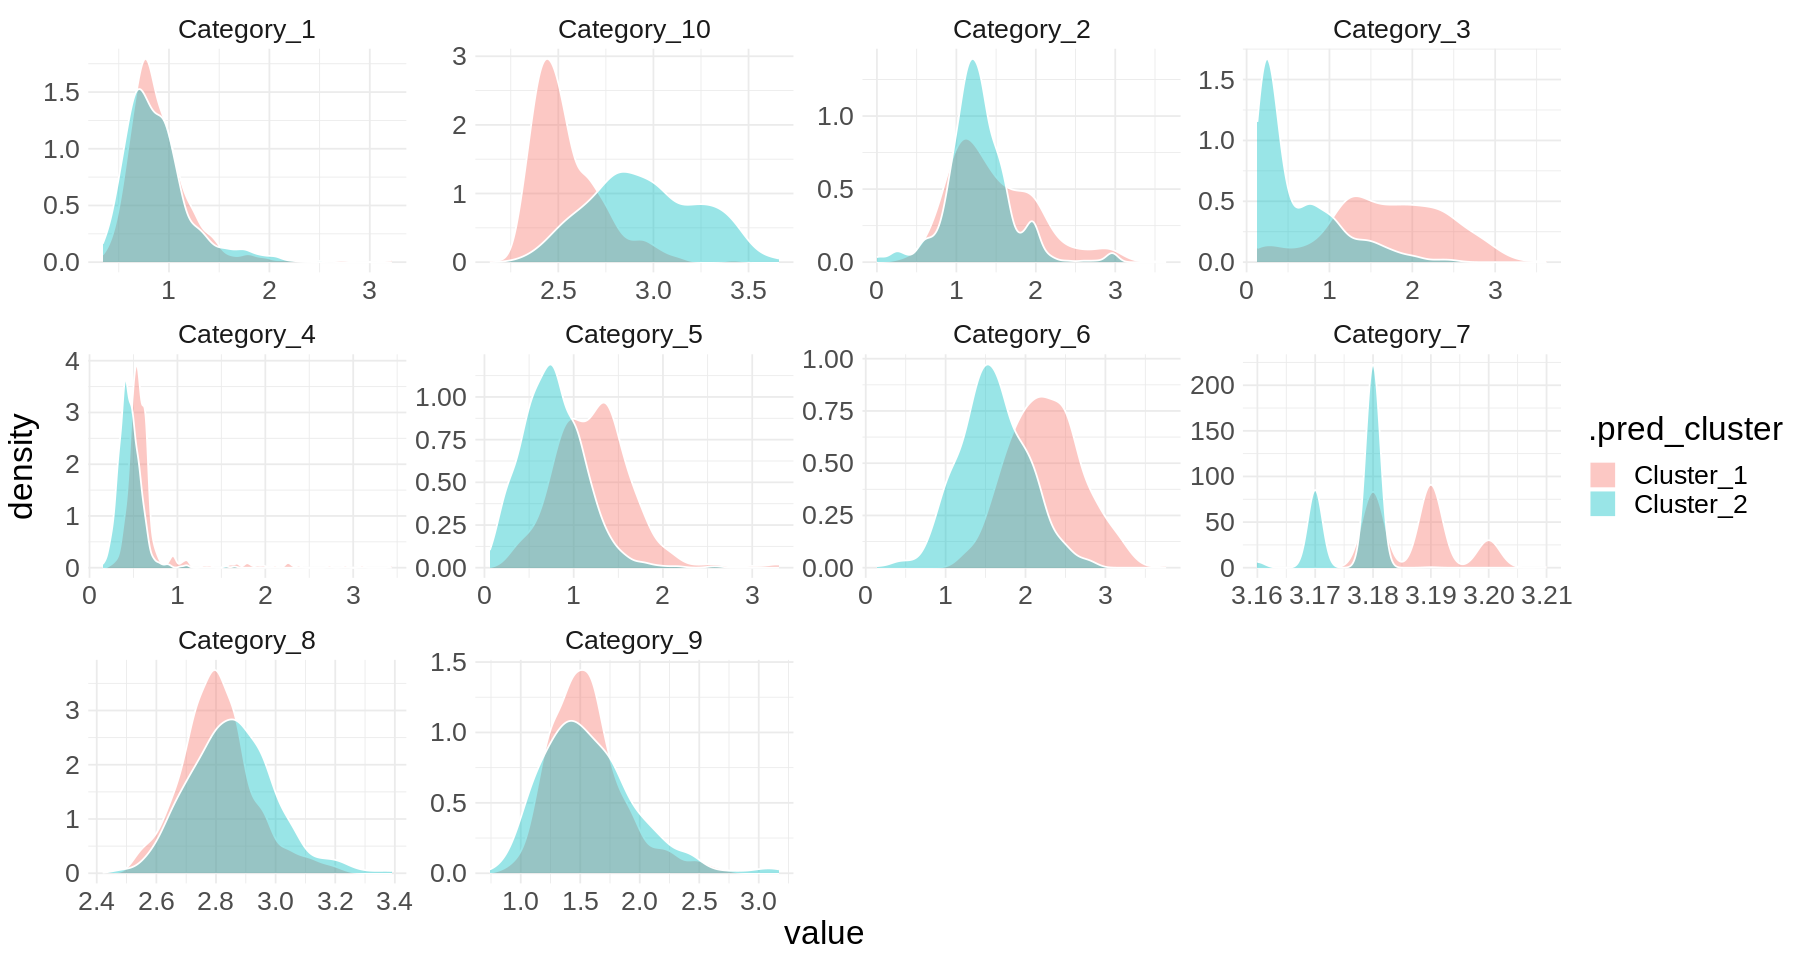

In [137]:
options(repr.plot.height = 8, repr.plot.width = 15)
cluster_assignments |>
    pivot_longer(cols = -.pred_cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .pred_cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        # We are setting the x-scale to "free" since we standardized the rating values before clustering them,
        # which means that their original range (which is what we show here) does not matter
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

**Question 2.4** Multiple Choice:
<br> {points: 1}

From the plots above, point out the categories that we might hypothesize are driving the clustering? (i.e., are useful to distinguish between the type of tourists?) We list the table of the categories below. 

- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

A. 10, 3, 5, 6, 7

B. 10, 3, 5, 6, 1

C. 10, 3, 4, 6, 7

D. 10, 2, 5, 6, 7

*Assign your answer to an object called `answer2.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [138]:
answer2.4 <- "B"

**Question 2.5** 
<br> {points: 3}

Discuss one disadvantage of not being able to visualize the clusters when dealing with multidimensional data.

visualizing the clusters allows us to ensure that we note and see patterns faster and that are harder to notice without the visualization. Patterns that occur in data that would be difficult to see for the clusters become far more readable in a visualized form espeically for multidimensional when there are many variable to consider. Seeing a clear graph allows a person to quickly and intuitaviely sort where the data clusters. Without visualizing this process becommes lengthy tedious and easy to have patterning looked over.


In [139]:
source("cleanup.R")